# Data
In google My Drive I have:

- Flickr30k_Dataset.zip
- glove.6B.zip

Then, you should be able to run through the notebook as is..  

This is based on https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8 at the AT3 suggested models

# Mounting the Drive
The zipped image and text files are stored in Google My Drive, so first the drive is mounted and then the files are downloaded, accessible in /root/.keras/datasets/

In [1]:
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Read the Images to Keras/datasets
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/31296_39911_bundle_archive.zip'
zip_dir = tf.keras.utils.get_file('31296_39911_bundle_archive.zip', origin=file_url, extract=True)
print(zip_dir)

# Read the Text files
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/glove.6B.zip'
glv_dir = tf.keras.utils.get_file('glove.6B.zip', origin=file_url, extract=True)
print(glv_dir)
root_directory = '/root/.keras/datasets/'


8765399040/8765396518 [==============================] - 657s 0us/step
/root/.keras/datasets/31296_39911_bundle_archive.zip
862183424/862182613 [==============================] - 20s 0us/step
/root/.keras/datasets/glove.6B.zip


In [5]:
import pathlib
parent_dir = pathlib.Path(zip_dir).parent
print(parent_dir)
path = parent_dir / 'flickr30k_images'

/root/.keras/datasets


Import Libraries to be used in the code.

In [6]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle #import dump, load
from time import time
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, add, Add, concatenate, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## Load Image Names and Captions

The flickr8k set has been split into Training, Test and Validation (Dev) set within different text files.  For flickr30k however, there is 1 results.csv file that contains:
- Filename
- Comment number (0-4)
- Comment

The file is pipe delimited.  Processing will read this into a dataframe and the comment number column is not required.

In [7]:
# Get the data labels
labels_file = "results.csv"
data_labels = pd.read_csv(path / labels_file, sep='|')
# Remove Comment Number column
data_labels = data_labels.drop(columns=' comment_number' ,axis = 1)
# Remove any labels that have NA description (1 record)
data_labels = data_labels.dropna()

In [22]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [28]:
root_directory = '/root/.keras/datasets/'
# load descriptions
#train_filelist = load_doc("drive/My Drive/Flickr_30k.trainImages.txt")
#test_filelist = load_doc("drive/My Drive/Flickr_30k.testImages.txt")
#val_filelist = load_doc("drive/My Drive/Flickr_30k.devImages.txt")
train_filelist = []
with open("drive/My Drive/Flickr_30k.trainImages.txt") as file:
    train_filelist = [line.strip() for line in file]
test_filelist = []
with open("drive/My Drive/Flickr_30k.testImages.txt") as file:
    test_filelist = [line.strip() for line in file]
val_filelist = []
with open("drive/My Drive/Flickr_30k.devImages.txt") as file:
    val_filelist = [line.strip() for line in file]

Data is then split into a training, test and validation sets.  First, the unique filenames are found as all comments for a filename must be wholly within either the train, test or validation.

Then the data is split into 20% for testing and 80% for Training/Validation.  The Training/Validation is then split into 10% Validation an 90% Training.

In [31]:
from sklearn.model_selection import train_test_split

root_directory = '/root/.keras/datasets/'
#train_filelist = root_directory + "Flickr_30k.trainImages.txt"
# load descriptions
#train_filelist = load_doc("drive/My Drive/Flickr_30k.trainImages.txt")
#test_filelist = load_doc("drive/My Drive/Flickr_30k.testImages.txt")
#val_filelist = load_doc("drive/My Drive/Flickr_30k.devImages.txt")

#filelist = data_labels['image_name'].unique().tolist()
#trainval_filelist, test_filelist = train_test_split(filelist, test_size=0.2, random_state=42)
#train_filelist, val_filelist = train_test_split(trainval_filelist, test_size=0.1, random_state=8029)
train_df = data_labels[data_labels['image_name'].isin(train_filelist)]
test_df = data_labels[data_labels['image_name'].isin(test_filelist)]
val_df = data_labels[data_labels['image_name'].isin(val_filelist)]
print(len(val_df['image_name'].unique()))
print(len(test_df['image_name'].unique()))
print(len(train_df['image_name'].unique()))

4000
3783
24000


# Loading the Data and Cleaning

Now, read the data_labels dataframe and for each unique image filename build a dictionary entry of the 5 captions.


In [32]:
# Load descriptions from data frame
def load_descriptions(doc):
   mapping = dict()
 
   for index, row in data_labels.iterrows():

		# take the first token as the image id, the rest as the description
     image_id, image_desc = row['image_name'], row[' comment']

		# extract filename from image id
     image_id = image_id.split('.')[0]

		# create the list if needed
     if image_id not in mapping:
       mapping[image_id] = list()
		# store description
     mapping[image_id].append(image_desc)
  
   return mapping

# parse descriptions
descriptions = load_descriptions(data_labels)
print('Loaded: %d ' % len(descriptions))

Loaded: 31783 


Clean the text by:
- Removing punctuation
- making everything lower case
- remove hanging 's' and 'a'
- remove numbers

In [33]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():

		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

Now create a vocabulary of words, so take the descriptions and make a list of unique words.

In [34]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 19735


Then save the descriptions to file.

In [35]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

# Load the Images

Create lists of the training filenames and the validation filenames.

In [36]:
train_1 = train_df['image_name'].unique().tolist()  
train = [i.split('.')[0] for i in train_1]
print('Dataset: %d' % len(train))
validation_1 = val_df['image_name'].unique().tolist()
validation = [i.split('.')[0] for i in validation_1]
print('Dataset: %d' % len(validation))

Dataset: 24000
Dataset: 4000


Then save a list of the full path and filename for all images, ready for loading.

In [37]:
# Below path contains all the images

root_directory = '/root/.keras/datasets/'
images = root_directory + 'flickr30k_images/flickr30k_images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')


Create lists for training, test and validation that contains the full pathname and filename for each image in the set

In [38]:
train_img = [images + s for s in train_df['image_name'].unique().tolist()]
test_img = [images + s for s in test_df['image_name'].unique().tolist()]
val_img = [images + s for s in val_df['image_name'].unique().tolist()]

Load the training descriptions from the file of descriptions created earlier. 'startseq' is added before the caption to denote the start of the sentence and 'endseq' is added at the end to denote the end of the sentence. 


In [39]:

	
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
val_descriptions = load_clean_descriptions('descriptions.txt', validation)
print('Descriptions: train=%d' % len(val_descriptions))

Descriptions: train=24000
Descriptions: train=4000


Create a function to preprocess each image for the inception model.  This will load the image in the correct size and format (nimpy array) and scale pixels between -1 and 1.

In [40]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

# Feature Extraction
Create an InceptionV3 model as a feature extractor.  This will create a 2,048 element vector as the output.  Since, the top layer is not included, average pooling is applied at the end to convert from a 4D tensor to a 2D tensor.

In [41]:
model_new = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3), pooling='avg')

In [ ]:
model_new.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

Below is a function to extract the features of the image.  It will 'predict' on the image to get a 2,048 element output.

In [42]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

The training set images are passed through the inception model to create the features.  The feature set is then saved as pickle file for use later.

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

The Test set images are also passed through the inception model to create their features.  The feature set is then saved as pickle file for use later.  This will be saved to My Drive so that it can be used in the Evaluation section without needing to be rebuilt - it is persisted.

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 291.9666483402252


In [ ]:
# Save the bottleneck test features to disk
with open("drive/My Drive/encoded_test_images_flickr30.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

Create features for the Validation Set.

In [ ]:
# Call the funtion to encode all the Validation images - Execute this only once
start = time()
encoding_val= {}
for img in val_img:
    encoding_val[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 118.38439011573792


In [ ]:
# Save the bottleneck test features to disk
with open("encoded_val_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle) 

In [ ]:
train_features = pickle.load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
val_features = pickle.load(open("encoded_val_images.pkl", "rb"))
print('Photos: val=%d' % len(val_features))

Photos: train=22883
Photos: val=2543


The original vocabulary size is 17,337 which includes rare words that do not help in a general model.  So any words that occur less than 10 times are removed.  An extra 'word' in the vocab list is added for '0', because sentences will be padded with 0 to give them a fixed length in processing.

This gives 4,626 words for the model's vocabulary.

In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

# Include validation set as well
#for key, val in val_descriptions.items():
#    for cap in val:
#        all_train_captions.append(cap)
#len(all_train_captions)

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 17337 -> 4626


Create two dictionaries, one for index to word and one for word to index.  Since the model can only use numeric data, words are converted to a token number and these 2 dictionaries give the mapping from word to token and token to word.

In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

4627

Save the WordtoIx and IxtoWord to an external pickle file so that it can be used in the evaluation section of the notebook without the need for re-runing the entire notebook.

In [ ]:
# Save wordtoix and ixtoword for evaluation section.
file = open('drive/My Drive/vocab_flickr30.pkl','wb')
pickle.dump(wordtoix, file)
pickle.dump(ixtoword, file)
pickle.dump(descriptions, file)
pickle.dump(max_length, file)
file.close()


Calculate the maximum number of words in the training sentences and this will become the length for each sentence.  This length includes the startseq and endseq words we added to each sentence earlier.

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


print(max_length(val_descriptions))
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: {}'.format(max_length))

59
Description Length: 74


## Data Generator
A data generator allows data to be processed in batches so that the model does not have to keep all the training data in memeory.  For the RNN, this will have as input the feature vector from the inception model as one input.  The model is predicting the next word in a sequence given the preceding words, so the second input is the increasing sequences of words, for example:
- startseg
- startseg, the
- startseg, the, cat
- startseg, the, cat, is
- startseg, the, cat, is, on
- startseg, the, cat, is, on, the
- startseg, the, cat, is, on, the, grass
- startseg, the, cat, is, on, the, grass, endseq

For each input, the next word is being predicted as Y.

So, the data generator returns the Feature vector, tokens for each increasing sequence and the predictions.

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [array(X1), array(X2)], array(y) # No brackets around the outside
                X1, X2, y = list(), list(), list()
                n=0

GloVE word embeddings are used to map each word index to a 200 dimensional vectore, giving an embedding matrix.

In [ ]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join(root_directory, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(4627, 200)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 =  Dropout(0.5)(se1)
se3 =  LSTM(256, dropout=0.22, recurrent_dropout=0.22, return_sequences=True)(se2)
bn1 = BatchNormalization(axis=-1)(se3)
d1 =  Dropout(0.3)(bn1)
se4 =  LSTM(256, return_sequences=True)(d1)#, dropout=0.22, recurrent_dropout=0.22, return_sequences=True)(se2)
bn2 = BatchNormalization(axis=-1)(se4)
d2 =  Dropout(0.3)(bn2)
se5 =  LSTM(256)(d2)
decoder1 =  add([fe2, se5])#, axis=1)
decoder2 =  Dense(256, activation='relu')(decoder1)
outputs =  Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
print(vocab_size)

2915


In [ ]:
model.layers[5]

We can load the embedding matrix that was create from the gloVE embeddings as the weights for the embedding layer and then freeze that layer so the weights remain as is.

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))
              

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 74)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 74, 200)      925400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
model_new.summary()

Set the number of Epochs to run for, batch size and steps for training the model.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001))
epochs = 5
number_pics_per_bath = 32
steps = len(train_descriptions)//number_pics_per_bath
val_steps = len(val_descriptions)//number_pics_per_bath

A problem with using the data generator from the dictionary of filnames and captions is that the order of the dictionary entries are fixed.  Ideally, for training the images should be shuffled so that it does not learn an order.  So the function below takes a dictionary, shuffles the entries randomly and returns the new dictionary.

In [ ]:
import random

def shuffleTest(train_descriptions):   
   keys =  list(train_descriptions.keys())
   random.shuffle(keys)

   Shuffledtrain_descriptions = {}
   for key in keys:
      Shuffledtrain_descriptions.update({key:train_descriptions[key]})

   return Shuffledtrain_descriptions

In each Epoch, the dictionary entries are shuffled so that images appear in different order for training.  Below runs through a loop of training and validation.

In [ ]:
for i in range(epochs):
    Shuffledtrain_descriptions = shuffleTest(train_descriptions)
    train_generator = data_generator(Shuffledtrain_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    val_generator = data_generator(val_descriptions, val_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(x=train_generator, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_generator, validation_steps=val_steps)

715/715 [==============================] - 119s 166ms/step - loss: 3.1082 - val_loss: 3.3491


In [ ]:
model.save('drive/My Drive/MeanGirls_flickr30.h5')

# Evaluation and Testing

This section will take the compiled model and run the held out test data against it.  Both Greedy and Beam search have been implemented to assess the quality of the generated captions.

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle #import dump, load
from time import time

In [ ]:
model = tf.keras.models.load_model('drive/My Drive/MeanGirls_flickr30.h5')

In [ ]:
root_directory = '/root/.keras/datasets/'
images = root_directory + 'flickr30k_images/flickr30k_images/'
max_length = 74

In [ ]:
with open("drive/My Drive/encoded_test_images_flickr30.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

file = open('drive/My Drive/vocab_flickr30.pkl', 'rb')
wordtoix = pickle.load(file)
ixtoword = pickle.load(file)
descriptions = pickle.load(file)
file.close()

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):

    start = [wordtoix["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            e = encoding_test[image].reshape((1,2048))  
            #e = encoding_test[image[len(images):]]
            preds = model.predict([e, np.array(par_caps)])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption


Create the Test descriptions for BLEU scores.  A smoothing function is used to avoid where there are 0 overlaps between n-grams.  This gives better results, with the BLEU score going from BLEU-1 to BLEU-4.

## Beam Search

In [ ]:
# cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
cc = SmoothingFunction()
bleu_1 = 0
bleu_2 = 0
bleu_3 = 0
bleu_4 = 0
i = 0

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 


for pic in encoding_test.keys():
  #  image = encoding_test[pic].reshape((1,2048))   
    fname, ext = pic.split('.')
    caption = beam_search_predictions(pic) # Do prediction
  #  caption = greedySearch(image) # Do prediction
    predicted = caption.split()
    actual = [d.split() for d in descriptions[fname]]
    if len(predicted) < 3:
      print(caption)
    i += 1
    if i % 200 == 0:
       print("Processed {} {} {} {} {}".format(i, bleu_1/i, bleu_2/i, bleu_3/i, bleu_4/i))
    bleu = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=cc.method1)
    bleu_1 += sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=cc.method1)
    bleu_2 += sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=cc.method1)
    bleu_3 += sentence_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=cc.method1)
    bleu_4 += sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=cc.method1)

    bleus.append(bleu)
    if bleu > 0.8:# and len(pred_good) < nkeep:
        pred_good.append((bleu,pic,descriptions[fname],caption))
    elif bleu < 0.2:# and len(pred_bad) < nkeep:
        pred_bad.append((bleu,pic,descriptions[fname],caption))
  
print('BLEU-1: {} '.format(bleu_1 / len(encoding_test.keys())))
print('BLEU-2: {} '.format(bleu_2 / len(encoding_test.keys())))
print('BLEU-3: {} '.format(bleu_3 / len(encoding_test.keys())))
print('BLEU-4: {} '.format(bleu_4 / len(encoding_test.keys())))

## Greedy Search

In [ ]:
# cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction#, sentence_nist, sentence_meteor
cc = SmoothingFunction()
bleu_1 = 0
bleu_2 = 0
bleu_3 = 0
bleu_4 = 0
i = 0

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 


for pic in encoding_test.keys():
    image = encoding_test[pic].reshape((1,2048))   
    fname, ext = pic.split('.')
  #  caption = beam_search_predictions(pic) # Do prediction
    caption = greedySearch(image) # Do prediction
    predicted = caption.split()
    actual = [d.split() for d in descriptions[fname]]
    if len(predicted) < 3:
      print(caption)
    i += 1
    if i % 50 == 0:
       print("Processed {} {} {} {} {}".format(i, bleu_1/i, bleu_2/i, bleu_3/i, bleu_4/i))
    bleu = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=cc.method1)
    bleu_1 += sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=cc.method1)
    bleu_2 += sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=cc.method1)
    bleu_3 += sentence_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=cc.method1)
    bleu_4 += sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=cc.method1)

    bleus.append(bleu)
    if bleu > 0.8:# and len(pred_good) < nkeep:
        pred_good.append((bleu,pic,descriptions[fname],caption))
    elif bleu < 0.2:# and len(pred_bad) < nkeep:
        pred_bad.append((bleu,pic,descriptions[fname],caption))
  
print('BLEU-1: {} '.format(bleu_1 / len(encoding_test.keys())))
print('BLEU-2: {} '.format(bleu_2 / len(encoding_test.keys())))
print('BLEU-3: {} '.format(bleu_3 / len(encoding_test.keys())))
print('BLEU-4: {} '.format(bleu_4 / len(encoding_test.keys())))

Processed 50 0.49150027928778717 0.2766309908697592 0.1438769361927162 0.08682017489064836
Processed 100 0.5098914692106192 0.2950608647000373 0.1718025954920744 0.10928184626052309
Processed 150 0.49420046726739714 0.2748274054673773 0.1591741613364933 0.10285529546615138
Processed 200 0.49500371470575977 0.27673255743233993 0.15633318300634408 0.09763047565966301
Processed 250 0.4963503599220527 0.2853937329249026 0.16642251895716767 0.10393590900417048
Processed 300 0.4979723329462925 0.28548657560762336 0.16609007869941153 0.10360226516549702
Processed 350 0.49883494766665026 0.287963543637434 0.16802599623408127 0.10427603202976922
Processed 400 0.4970908668865075 0.28914081541137304 0.17043763684976887 0.10611113594844947
Processed 450 0.4979661028115324 0.28792671326810426 0.16867565723537464 0.10567795223951229


KeyboardInterrupt: ignored

In [ ]:
import nltk
print(nltk.__version__)

3.5


Amended from https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html

Bad Caption
118309463.jpg
12252043.jpg
137431253.jpg
1353009866.jpg
153598671.jpg


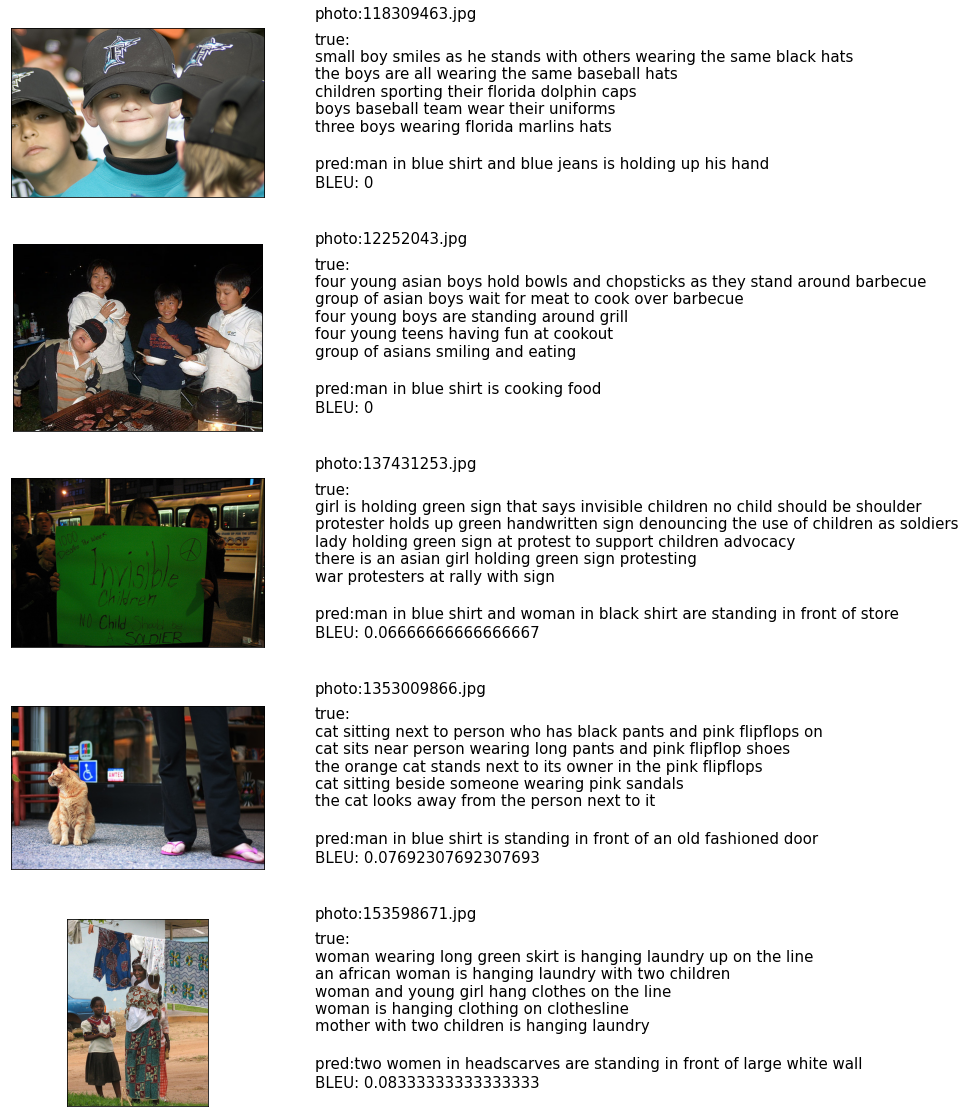

Good Caption
1412318227.jpg
1434155791.jpg
1465666502.jpg
1470132731.jpg
156205911.jpg


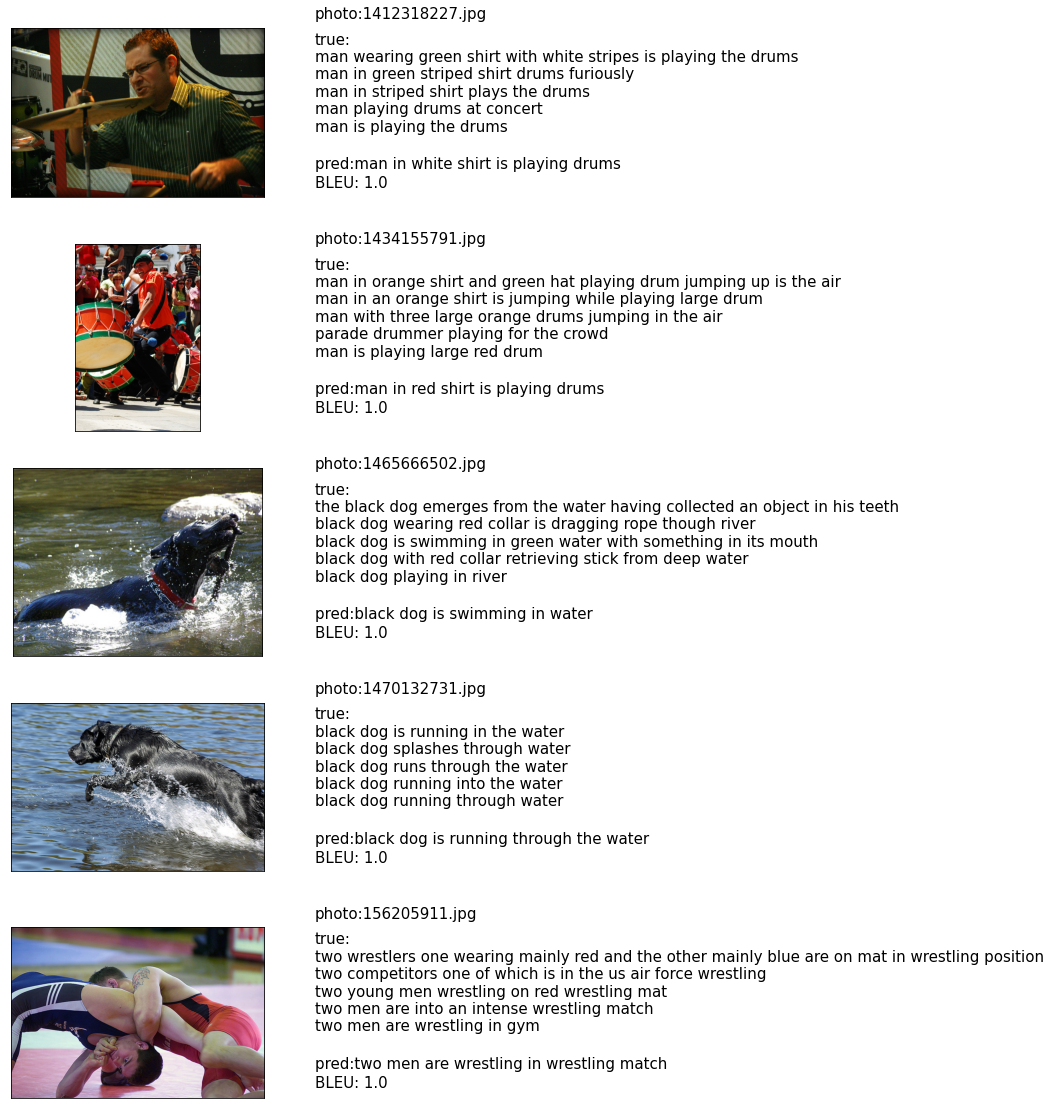

In [ ]:
def plot_images(pred_bad, type='good', npic=5):
    def create_str(caption_true):
        strue = ""
        for s in list(caption_true):
            strue += "\n" + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    pred = pred_bad.copy()
    pred.sort()
    # Either get top n (good) or bottom n (bad) images to show
    if type == 'good':
       pred = pred[-npic:]
    else:
       pred = pred[:npic]
    fig = plt.figure(figsize=(10,npic*4))
    for pb in pred:
        bleu,pic,actual,caption = pb
        ## images - get image from array, reshape and display in column 1
        image = encoding_test[pic].reshape((1,2048))
        x=plt.imread(images+pic)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(x)
        count += 1
        ## Text - get true descriptions, predicted and BLEU-1 score and display in column 2
        actual = create_str(actual) # Split the 5 descriptions to separate lines
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,1,"photo:" + pic,fontsize=15)
        ax.text(0,0.4,"true:" + actual,fontsize=15)
        ax.text(0,0.2,"pred:" + caption,fontsize=15)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=15)
        count += 1
        
        print(pic)
    plt.show()

print("Bad Caption")
plot_images(pred_bad, 'bad')
print("Good Caption")
plot_images(pred_good, 'good')

In [ ]:
Ctrl shift i put in console to keep connected
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);